# Agentic RAG From Scratch: Building with LangGraph and Open-Source Models

In this notebook, we'll look under the hood of `create_agent` and build an agentic RAG application **from scratch** using LangGraph's low-level primitives and locally-hosted open-source models.

**Learning Objectives:**
- Understand LangGraph's core constructs: StateGraph, nodes, edges, and conditional routing
- Build a ReAct agent from scratch without high-level abstractions
- Use Ollama to run open-source models locally (gpt-oss:20b + embeddinggemma)
- Transition from `aimakerspace` utilities to the LangChain ecosystem

## Table of Contents:

- **Breakout Room #1:** LangGraph Fundamentals & Building Agents from Scratch
  - Task 1: Dependencies & Ollama Setup
  - Task 2: LangGraph Core Concepts (StateGraph, Nodes, Edges)
  - Task 3: Building a ReAct Agent from Scratch
  - Task 4: Adding Tools to Your Agent
  - Question #1 & Question #2
  - Activity #1: Implement a Custom Routing Function

- **Breakout Room #2:** Agentic RAG with Local Models
  - Task 5: Loading & Chunking with LangChain
  - Task 6: Setting up Qdrant with Local Embeddings
  - Task 7: Creating a RAG Tool
  - Task 8: Building Agentic RAG from Scratch
  - Question #3 & Question #4
  - Activity #2: Extend the Agent with Memory

---
# Breakout Room #1
## LangGraph Fundamentals & Building Agents from Scratch

## Task 1: Dependencies & Ollama Setup

Before we begin, make sure you have:

1. **Ollama installed** - Download from [ollama.com](https://ollama.com/)
2. **Ollama running** - Start with `ollama serve` in a terminal
3. **Models pulled** - Run these commands:

```bash
# Chat model for reasoning and generation (~12GB)
ollama pull gpt-oss:20b

# my mac is old so did
ollama pull llama2:13b

# Embedding model for RAG (~622MB)
ollama pull embeddinggemma
```

> **Note**: If you don't have enough RAM/VRAM for `gpt-oss:20b` (requires 16GB+ VRAM or 24GB+ RAM), you can substitute with `llama3.2:3b` or another smaller model.

**📚 Documentation:**
- [Ollama Installation Guide](https://ollama.com/download)
- [gpt-oss Model Card](https://ollama.com/library/gpt-oss)
- [EmbeddingGemma Model Card](https://ollama.com/library/embeddinggemma)
- [langchain-ollama Integration](https://python.langchain.com/docs/integrations/providers/ollama/)

In [1]:
# Core imports we'll use throughout the notebook
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [2]:
### SETENV
import os
import openai
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key
langchain_key = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_PROJECT"] = "pr-ample-bean-55"
os.environ["LANGSMITH_PROJECT"] = "pr-ample-bean-55"
os.environ["LANGCHAIN_API_KEY"] = langchain_key


if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")


LangSmith tracing enabled. Project: pr-ample-bean-55


In [3]:
# # lets test langsmith configuration
from dotenv import load_dotenv
import os

load_dotenv()

issues = []

if os.getenv("LANGCHAIN_TRACING_V2") != "true":
    issues.append("❌ LANGCHAIN_TRACING_V2 is not 'true'")
else:
    print("✅ LANGCHAIN_TRACING_V2 = true")

if not os.getenv("LANGCHAIN_API_KEY"):
    issues.append("❌ LANGCHAIN_API_KEY is not set")
else:
    print("✅ LANGCHAIN_API_KEY is set")

project = os.getenv("LANGCHAIN_PROJECT")
if not project:
    issues.append("⚠️ LANGCHAIN_PROJECT not set (will use 'default')")
else:
    print(f"✅ LANGCHAIN_PROJECT = {project}")

if issues:
    print("\nIssues found:")
    for issue in issues:
        print(f"  {issue}")
else:
    print("\n✅ All environment variables look good!")


from langsmith import Client

client = Client()
try:
    projects = list(client.list_projects(limit=3))
    print("✅ LangSmith connection works!")
    print("Your projects:", [p.name for p in projects])
except Exception as e:
    print(f"❌ LangSmith connection failed: {e}")


from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
response = llm.invoke("Say hello in French")
print(response.content)

from langchain.agents import create_agent
from langsmith import traceable

@traceable
def format_prompt(subject):
    "TEST LANGSMITH TRACING!!!"+subject
    print("TEST LANGSMITH TRACING!!!"+subject)
test_langsmith = format_prompt("LangSmith")

def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"


agent = create_agent(
    model="openai:gpt-5-mini",
    tools=[get_weather],
    system_prompt="You are a helpful assistant",
)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "What is the weather in San Francisco?"}]}
)

✅ LANGCHAIN_TRACING_V2 = true
✅ LANGCHAIN_API_KEY is set
✅ LANGCHAIN_PROJECT = pr-ample-bean-55

✅ All environment variables look good!
✅ LangSmith connection works!
Your projects: ['pr-ample-bean-55', 'AIE9 - The Agent Loop - f45471ab', 'AIE9 - The Agent Loop - f84c617b']
Hello in French is "Bonjour."
TEST LANGSMITH TRACING!!!LangSmith


{'messages': [HumanMessage(content='What is the weather in San Francisco?', additional_kwargs={}, response_metadata={}, id='65860c3c-7b24-4dd5-9e45-a9d269567cd8'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 142, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D1gUgqwkzINwEGCK6XpaMayMvbhZp', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bf224-a31a-7203-95b8-6b0dd53f3098-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'San Francisco'}, 'id': 'call_6b2oKDJ6TPjnsjeMGwMM8GTP', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 142, 

In [4]:
# # Verify Ollama is running and models are available
# from langchain_ollama import ChatOllama, OllamaEmbeddings
# usedModel = "llama2:13b" # "llama2:13b", "gpt-oss:20b"
# # had to
# # ollama pull llama2:13b
# # ollama pull embeddinggemma
# # one window ollama run llama2:13b
# # one window ollama run embeddinggemma -> didnt work.. 
# # Test connection to Ollama
# try:
#     test_llm = ChatOllama(model=usedModel, temperature=0)
#     test_response = test_llm.invoke("Say 'Ollama is working!' in exactly 3 words.")
#     print(f"Chat Model Test: {test_response.content}")
    
#     test_embeddings = OllamaEmbeddings(model="embeddinggemma")
#     test_vector = test_embeddings.embed_query("test")
#     print(f"Embedding Model Test: Vector dimension = {len(test_vector)}")
#     print("\nOllama is ready!")
# except Exception as e:
#     print(f"Error connecting to Ollama: {e}")
#     print("\nMake sure:")
#     print("1. Ollama is installed: https://ollama.com/")
#     print("2. Ollama is running: 'ollama serve'")
#     print("3. Models are pulled: 'ollama pull gpt-oss:20b' and 'ollama pull embeddinggemma'")

## Task 2: LangGraph Core Concepts

In Session 3, we used `create_agent` which abstracts away the complexity. Now let's understand what's happening under the hood!

### LangGraph models workflows as **graphs** with three key components:

### 1. State
A shared data structure that represents the current snapshot of your application:

```python
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
```

The `add_messages` **reducer** ensures new messages are appended (not replaced) when the state updates.

### 2. Nodes
Python functions that encode the logic of your agent:
- Receive the current state
- Perform computation or side-effects
- Return an updated state

### 3. Edges
Functions that determine which node to execute next:
- **Normal edges**: Always go to a specific node
- **Conditional edges**: Choose the next node based on state

**📚 Documentation:**
- [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)
- [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [StateGraph API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)

In [5]:
# Let's build our first LangGraph workflow - a simple echo graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Define the State
class SimpleState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 2: Define Nodes (functions that process state)
def echo_node(state: SimpleState):
    """A simple node that echoes the last message."""
    last_message = state["messages"][-1]
    echo_response = AIMessage(content=f"You said: {last_message.content}")
    return {"messages": [echo_response]}

# Step 3: Build the Graph
echo_graph = StateGraph(SimpleState)

# Add nodes
echo_graph.add_node("echo", echo_node)

# Add edges (START -> echo -> END)
echo_graph.add_edge(START, "echo")
echo_graph.add_edge("echo", END)

# Compile the graph
echo_app = echo_graph.compile()

print("Simple echo graph created!")

Simple echo graph created!


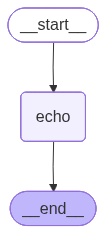

In [6]:
# Visualize the graph structure
try:
    from IPython.display import display, Image
    display(Image(echo_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(echo_app.get_graph().draw_ascii())

In [7]:
# Test the echo graph
result = echo_app.invoke({"messages": [HumanMessage(content="Hello, LangGraph!")]})

print("Conversation:")
for msg in result["messages"]:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  [{role}]: {msg.content}")

Conversation:
  [Human]: Hello, LangGraph!
  [AI]: You said: Hello, LangGraph!


## Task 3: Building a ReAct Agent from Scratch

Now let's build something more sophisticated: a **ReAct agent** that can:
1. **Reason** about what to do
2. **Act** by calling tools
3. **Observe** results
4. **Repeat** until done

This is exactly what `create_agent` does under the hood. Let's build it ourselves!

### The Agent Loop Architecture

```
                    ┌──────────────┐
                    │    START     │
                    └──────┬───────┘
                           │
                           ▼
                    ┌──────────────┐
             ┌─────►│    agent     │◄────────┐
             │      │  (call LLM)  │         │
             │      └──────┬───────┘         │
             │             │                 │
             │             ▼                 │
             │      ┌──────────────┐         │
             │      │ should_      │         │
             │      │ continue?    │         │
             │      └──────┬───────┘         │
             │             │                 │
             │    tool_calls?                │
             │     │           │             │
             │    YES         NO             │
             │     │           │             │
             │     ▼           ▼             │
             │ ┌────────┐  ┌───────┐         │
             │ │ tools  │  │  END  │         │
             └─┤(execute│  └───────┘         │
               │ tools) ├────────────────────┘
               └────────┘
```

**📚 Documentation:**
- [How to create a ReAct agent from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)
- [ReAct Agent Conceptual Guide](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent)

In [8]:
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Step 1: Define the Agent State
class AgentState(TypedDict):
    """The state of our agent - just a list of messages."""
    messages: Annotated[list[BaseMessage], add_messages]

print("AgentState defined with messages field")

AgentState defined with messages field


In [9]:
# Step 2: Initialize our local LLM with Ollama
# Per above, defaulting back to openai for now since I cant get a model that supports tool calls locally.

# llm = ChatOllama(
#     model=usedModel,
#     temperature=0,  # Deterministic for reproducibility
# )

# print(f"LLM initialized: {llm.model}")

## Task 4: Adding Tools to Your Agent

Tools are functions that the agent can call. We use the `@tool` decorator and **bind** them to the LLM.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [@tool Decorator Reference](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)

In [10]:
# Step 3: Define Tools
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"


import math
# HW create custom square root tool
@tool
def return_sqrt(num: int):
    """
    Your tool should return the square root of any number you are given
    
    Args:
    num: The number to find the square root of
    """
    return str(math.sqrt(num))

# Create our tool list
tools = [calculate, get_current_time, return_sqrt]
# Bind tools to the LLM - this tells the LLM about available tools
llm_with_tools = llm.bind_tools(tools)

print("Tools defined and bound to LLM:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools defined and bound to LLM:
  - calculate: Evaluate a mathematical expression. Use this for a...
  - get_current_time: Get the current date and time. Use this when the u...
  - return_sqrt: Your tool should return the square root of any num...


In [11]:
# Step 4: Define the Agent Node (calls the LLM)
SYSTEM_PROMPT = """You are a helpful assistant that can perform calculations and tell the time.
Always use the available tools when appropriate.
Be concise in your responses."""

def agent_node(state: AgentState):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {"messages": [response]}

print("Agent node defined")

Agent node defined


In [12]:
# Step 5: Define the Tool Node (executes tools)
# We can use LangGraph's prebuilt ToolNode for convenience
tool_node = ToolNode(tools)

print("Tool node created using ToolNode prebuilt")

Tool node created using ToolNode prebuilt


In [13]:
# Step 6: Define the Conditional Edge (routing logic)
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Conditional routing function defined")

Conditional routing function defined


In [14]:
# Step 7: Build the Graph!
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "agent")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

ReAct agent built from scratch!


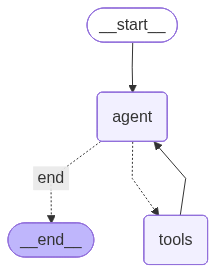

In [15]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [16]:
# Test our agent!
print("Testing our from-scratch agent:")
print("=" * 50)

response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48? and what is the time?")]})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing our from-scratch agent:

Conversation:
  [HumanMessage]: What is 25 * 48? and what is the time?
  [AIMessage]: [Tool calls: [{'name': 'calculate', 'args': {'expression': '25 * 48'}, 'id': 'call_KNtSBlduBTbLXKOzLMidYqyZ', 'type': 'tool_call'}, {'name': 'get_current_time', 'args': {}, 'id': 'call_v6YPP7J8BwTb8b4
  [ToolMessage]: The result of 25 * 48 is 1200
  [ToolMessage]: The current date and time is: 2026-01-24 17:34:13
  [AIMessage]: The result of 25 * 48 is 1200.  
The current date and time is: January 24, 2026, 17:34:13.


A Note about OS versoins and compatbility
Due to my MacOSX v 12 I was unable to support any model that supported noative tool calls locally..  I couldnt install the desired model

`
Trogdor:AIE9 dereky$ ollama pull gpt-oss:20b
pulling manifest 
Error: pull model manifest: 412: 

The model you are attempting to pull requires a newer version of Ollama.
`

I tried the latest supported  llama2 version but that didn't have the ability to call tools, actually none of them did. (See trace below)
I had to use VertexAI workbench to work around this and code there.
the resulting notebook was built on a Vertex Hosted Instance and ported back/



ResponseError                             Traceback (most recent call last)
Cell In[23], line 5
      2 print("Testing our from-scratch agent:")
      3 print("=" * 50)
----> 5 response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48?")]})
      7 print("\nConversation:")
      8 for msg in response["messages"]:

File ~/old/personal/code/ai-makerspace-code/AIE9/.venv/lib/python3.12/site-packages/langgraph/pregel/main.py:3071, in Pregel.invoke(self, input, config, context, stream_mode, print_mode, output_keys, interrupt_before, interrupt_after, durability, **kwargs)
   3068 chunks: list[dict[str, Any] | Any] = []
   3069 interrupts: list[Interrupt] = []
-> 3071 for chunk in self.stream(
   3072     input,
   3073     config,
   3074     context=context,
   3075     stream_mode=["updates", "values"]
   3076     if stream_mode == "values"
   3077     else stream_mode,
   3078     print_mode=print_mode,
   3079     output_keys=output_keys,
   3080     interrupt_before=interrupt_before,
   3081     interrupt_after=interrupt_after,
   3082     durability=durability,
   3083     **kwargs,
...
    181 for line in r.iter_lines():
    182   part = json.loads(line)

ResponseError: registry.ollama.ai/library/llama2:13b does not support tools (status code: 400)
During task with name 'agent' and id '0fa67bc1-c9c6-410a-5ba4-a48ab03d34d0'
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...

In [17]:
# Test with multiple tools
print("Testing with multiple tool calls:")
print("=" * 50)

response = agent.invoke({
    "messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with multiple tool calls:

Final response:
The current time is 17:34. The result of 100 divided by the current hour (17) is approximately 5.88.


In [18]:
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {"messages": [HumanMessage(content="Calculate 15% of 200")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: agent]
  Tool calls: ['calculate']

[Node: tools]
  Content: The result of 200 * 0.15 is 30.0

[Node: agent]
  Content: 15% of 200 is 30.


---
## ❓ Question #1:

In our from-scratch agent, we defined a `should_continue` function that returns either `"tools"` or `"end"`. How does this compare to how `create_agent` handles the same decision? What additional logic might `create_agent` include that we didn't implement?

##### Answer:

###### create_agent inner workings
create_agent has an internal "agent loop" which essentially does the same thing with some extras.  It will basically has these components and follows the actions.

* Agent (planner/decider): the LLM + prompt + output parser that produces either:
  * “call tool X with args Y”, or
  * “final answer”
* Executor / Runner: the loop that:
  * feeds observations back to the agent,
  * runs tools,
  * enforces limits (max iterations, timeouts),
  * handles errors

###### create_agent compared to our should_continue
create_agent had a tool loop and a 'complete' block.
In both cases the LLM decided WHICH tool to call.
In our case the should_continue logic was very simple

> ```python
> if we have a tool return it
> ```
> ```python
> else return 'end'
> ```


That code is placed as a conditional_edge between the agent and either a tool call or the END of the DAG

The additional logic in create_agent is detailed below.  Basically a lot of the blocking and tackling of errors, timeouts, loops, etc are covered by the framework so we dont have to worry about them.

###### create_agent additional logic
create_agent has some built in additional logic that we don't have to implement:
* max_iterations - it will stop if a condition is met where the agent is looping
* max_execution_time - after a max time it will stop and return, preventing overly long running tasks
* parsing-error recovery - if the model outputs malformed JSON or invalid tool args the error will be caught and either retry the LLM with messaging to try to fix or have the model treat this as an observation and the model will try to correct the error
* tool exception handling - if a tool returns an exception, the model will treat the error as an observation and may retry the tool call
* Multi-tool calls per turn - the tool calling infrastructure can emit several tool calls at once and feed all the results back to the model and re-query the model.






## ❓ Question #2:

We used `ToolNode` from `langgraph.prebuilt` to execute tools. Looking at the tool execution flow, what would happen if we wanted to add logging, error handling, or rate limiting to tool execution? How would building our own tool node give us more control?

##### Answer:

ToolNode standardizes “take the model’s tool calls → run them → write tool results back into state.” 
At a high level, ToolNode does something like:
* Read the most recent assistant message from state
* Extract tool_calls
* For each tool call:
  * find the matching tool by name
  * execute it with args
  * package the result as a ToolMessage
  * Append those tool result messages back into the conversation state

We have an issue if we want to add logging, error handling or rate-limiting while using ToolNode. The problem is you can log around ToolNode but not inside it.  Any errors, issues, or timeouts etc would be opaque to us, and we're reliant on what ToolNode passes back. 
We would maybe write a wrapper around ToolNode to standardize it, but again you dont get the internals and you can't control timeouts from OUTSIDE of the ToolNode call you can only log.  
The only way to enforce real changes would be a new replacement class for ToolNode like ToolNodeWithExtras or CustomToolNode.


Inside of CustomToolNode we would then be able to: 
* emit logs per tool call
* wraps tool executions in timeout + retry
* implement a rate limiter
* emits consistent error ToolMessages back to the LLM

Ideally our CustomToolNode would take LOTS of configuration on how to implement these patterns.  Ideally you pass classes to handle the rate limiting, logging specs, the timeout and retry values, etc..  this makes sure we get what we want and can extend it over time.


> ```python
> CustomToolNode (
    loggingSpec,
    retrySpec,
    rateLimiterSpec,
    preToolHook,
    postToolHook 
    )
> ```
and so on..




---
## 🏗️ Activity #1: Implement a Custom Routing Function

Extend the agent by implementing a **custom routing function** that adds more sophisticated logic.

Ideas:
- Add a maximum iteration limit to prevent infinite loops
- Route to different nodes based on the type of tool being called
- Add a "thinking" step before tool execution

Requirements:
1. Modify the `should_continue` function or create a new one
2. Add any new nodes if needed
3. Rebuild and test the agent

**📚 Documentation:**
- [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)
- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

In [19]:
### YOUR CODE HERE ###
# Here I added a "thinking" node that will be called if the LLM returns a tool call.
# It will then return a message to the user that we are thinking about their problem.
# Then the tool node will be called and the results will be added to the state.
# The agent will then continue.
# Initially I tried to push an AIMessage to the state but it was not working 
# openai.BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_6XDApRWYDWXSJOfcNrgkXL3B, call_f96mDs51nNgNbIdxj6HyDFxX", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}
# something I wasn't aware that you can't push nodes back on that are AI nodes like this, so we just emit the message to the user here
# Design decision to make the state machine simpler was to say if there are no tools there is no 'thinking' node.


# Example: Add iteration tracking to prevent infinite loops
class AgentStateWithCounter(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    iteration_count: int
    thinking_done: bool

def thinking_node(state: AgentStateWithCounter) -> str:
    """Produce some text that will be displayed to the user which repeats back what they asked for."""
    first_human_message = next(x for x in state['messages'] if isinstance(x, HumanMessage))
    print("thinking about your problem... "+first_human_message.content)
    return {
        "thinking_done": True
    }
    # "messages": [AIMessage(content="thinking about your problem..."+first_human_message.content)]

def custom_should_continue(state: AgentStateWithCounter) -> Literal["tools", "end", "thinking"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools node
    # if we havent spit out the thinking message yet, do it, set a flag in state
    # then next time we will be thinking_done and call the tool.
    if state.get('thinking_done') and hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    elif not state.get('thinking_done') and hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "thinking"
    else:
        return "end"
# Build your custom agent
# Step 7: Build the Graph!
workflow2 = StateGraph(AgentStateWithCounter)

# Add nodes
workflow2.add_node("agent", agent_node)
workflow2.add_node("thinking", thinking_node)
workflow2.add_node("tools", tool_node)

# Set the entry point
workflow2.add_edge(START, "agent")

# Add conditional edge from agent
workflow2.add_conditional_edges(
    "agent",
    custom_should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "thinking": "thinking", # If should_continue returns "thinking", go to thinking node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow2.add_edge("thinking", "tools")
workflow2.add_edge("tools", "agent")

# Compile the graph
agent2 = workflow2.compile()

print("ReAct agent built from scratch!")

ReAct agent built from scratch!


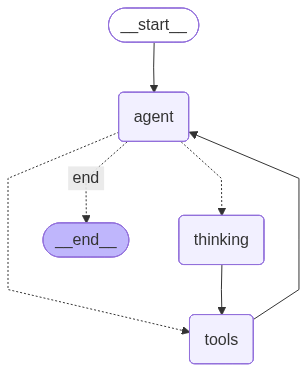

In [44]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(agent2.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(agent2.get_graph().draw_ascii())

In [45]:
# Test your custom agent
# Test with multiple tools
print("Testing with custom_should_continue:")
print("=" * 50)

response = agent2.invoke({
    "messages": [HumanMessage(content="What time is it,  return the square root of 100?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with custom_should_continue:
thinking about your problem... What time is it,  return the square root of 100?

Final response:
The current time is 17:49:14. The square root of 100 is 10.


---
# Breakout Room #2
## Agentic RAG with Local Models

Now let's build a full **Agentic RAG** system from scratch using our local models!

We'll transition from the `aimakerspace` utilities to the **LangChain ecosystem**:

| Task | aimakerspace | LangChain |
|------|--------------|----------|
| Load Documents | `TextFileLoader` | `TextLoader` |
| Split Text | `CharacterTextSplitter` | `RecursiveCharacterTextSplitter` |
| Embeddings | Custom | `OllamaEmbeddings` |

## Task 5: Loading & Chunking with LangChain

Let's use LangChain's document loaders and text splitters.

**📚 Documentation:**
- [Document Loaders Conceptual Guide](https://python.langchain.com/docs/concepts/document_loaders/)
- [TextLoader Reference](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.text.TextLoader.html)
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- [Text Splitters Conceptual Guide](https://python.langchain.com/docs/concepts/text_splitters/)

In [22]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the document using LangChain's TextLoader
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc.page_content) for doc in documents):,}")
print(f"\nDocument metadata: {documents[0].metadata}")

Loaded 1 document(s)
Total characters: 16,206

Document metadata: {'source': 'data/HealthWellnessGuide.txt'}


In [23]:
# Split documents using RecursiveCharacterTextSplitter
# This is more sophisticated than simple character splitting!

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    # Default separators: ["\n\n", "\n", " ", ""]
    # Tries to keep paragraphs, then sentences, then words together
)

chunks = text_splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk (first 300 chars):")
print("-" * 50)
print(chunks[0].page_content[:300] + "...")

Split into 45 chunks

Sample chunk (first 300 chars):
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 6: Setting up Qdrant with Local Embeddings

Now we'll use **OllamaEmbeddings** with the `embeddinggemma` model - completely local!

**📚 Documentation:**
- [OllamaEmbeddings Reference](https://python.langchain.com/api_reference/ollama/embeddings/langchain_ollama.embeddings.OllamaEmbeddings.html)
- [Qdrant Vector Store Integration](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Embedding Models Conceptual Guide](https://python.langchain.com/docs/concepts/embedding_models/)
- [EmbeddingGemma Overview (Google)](https://ai.google.dev/gemma/docs/embeddinggemma)

In [24]:
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize local embedding model
embedding_model = OllamaEmbeddings(model="embeddinggemma")
#embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
# here still using the embeddinggemma model for embeddings
# just needed to do 'ollama serve' to start the embedding model locally

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")
print(f"Using local model: embeddinggemma")

Embedding dimension: 768
Using local model: embeddinggemma


In [25]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base_local"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base_local


In [26]:
# Create vector store and add documents
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
print("Adding documents to vector store (this may take a moment with local embeddings)...")
vector_store.add_documents(chunks)
print(f"Added {len(chunks)} documents to vector store")

Adding documents to vector store (this may take a moment with local embeddings)...
Added 45 documents to vector store


In [27]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
Chapter 3: Building a Workout Routine

Starting a new exercise routine can feel overwhelming. The key is to start slowly and gradually increase intensity and duration over time....

--- Document 2 ---
Adults typically need 7-9 hours of sleep per night. Sleep occurs in cycles of about 90 minutes, alternating between REM (rapid eye movement) and non-REM sleep.

The four stages of sleep:
- Stage 1: Li...

--- Document 3 ---
- Chin Tucks: While sitting or standing tall, pull your chin back to create a "double chin." Hold for 5 seconds, repeat 10 times....


## Task 7: Creating a RAG Tool

Now let's wrap our retriever as a tool that the agent can use.

In [28]:
@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"RAG tool created: {search_wellness_knowledge.name}")

RAG tool created: search_wellness_knowledge


## Task 8: Building Agentic RAG from Scratch

Now let's put it all together - a complete agentic RAG system built from scratch!

In [29]:
# Define all tools for our RAG agent
rag_tools = [search_wellness_knowledge, calculate, get_current_time, return_sqrt]

# Bind tools to the LLM
rag_llm_with_tools = llm.bind_tools(rag_tools)

print("Tools for RAG agent:")
for t in rag_tools:
    print(f"  - {t.name}")

Tools for RAG agent:
  - search_wellness_knowledge
  - calculate
  - get_current_time
  - return_sqrt


In [30]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. ALWAYS search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with wellness system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")

RAG agent node defined


In [31]:
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile()

print("Agentic RAG built from scratch")

Agentic RAG built from scratch


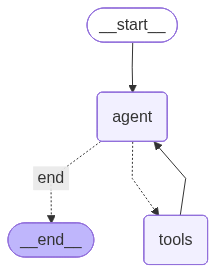

In [32]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(rag_agent.get_graph().draw_ascii())

In [33]:
# Test the RAG agent
print("Testing Agentic RAG (with local models):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What are some tips for better sleep?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Agentic RAG (with local models):

Final Response:
Here are some effective tips for better sleep:

1. **Consistent Sleep Schedule**: Try to go to bed and wake up at the same time each day, even on weekends. This helps regulate your body's internal clock.

2. **Relaxing Bedtime Routine**: Establish a calming pre-sleep routine, such as reading, gentle stretching, or taking a warm bath. This signals your body that it's time to wind down.

3. **Ideal Sleep Environment**: Keep your bedroom cool, dark, and quiet. Consider blackout curtains, eye masks, or white noise machines if needed.

4. **Limit Screen Exposure**: Reduce screen time at least 1-2 hours before bed. The blue light emitted by screens can interfere with your ability to fall asleep.

5. **Monitor Caffeine Intake**: Avoid consuming caffeine in the afternoon and evening, preferably after 2 PM, as it can disrupt sleep.

6. **Regular Exercise**: Engage in regular physical activity, but try not to exercise too close to bedtime

In [34]:
# Test with a complex query requiring both RAG and calculation
print("Testing with complex query:")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(
        content="I'm stressed and sleeping poorly. What should I do? Also, if I sleep 6 hours a night for a week, how many total hours is that?"
    )]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query:

Final Response:
It sounds like you’re going through a tough time with stress and sleep issues. Here are some suggestions that can help:

1. **Stress Management Techniques**:
   - **Exercise**: Physical activity can be a great stress reliever. Even a short walk can help lift your mood.
   - **Mindfulness and Meditation**: Practicing mindfulness or meditation can help calm your mind and reduce stress.
   - **Deep Breathing Exercises**: Take slow, deep breaths to help lower stress levels.
   - **Talk it Out**: Sometimes, talking to a friend or a mental health professional can relieve some stress.

2. **Improving Sleep Quality**:
   - **Establish a Sleep Routine**: Go to bed and wake up at the same time every day to regulate your body's clock.
   - **Create a Relaxing Environment**: Make sure your sleeping area is quiet, dark, and cool, and avoid screens before bedtime.
   - **Limit Caffeine and Heavy Meals Before Sleep**: Avoid consuming caffeine and heavy foo

In [35]:
# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is 125 * 8?")]
})

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
The result of \( 125 \times 8 \) is 1000. If you have any other questions or need help with wellness topics, feel free to ask!


---
## ❓ Question #3:

Compare the experience of building an agent from scratch with LangGraph versus using `create_agent` from Session 3. What are the trade-offs between control and convenience? When would you choose one approach over the other?

##### Answer:

###### Comparing Assignment 3 and 4.
Building with LangGraph was more labor intensive, we had to make each node and edge explicitly AND define the exact graph AND bind the tools.  In our very small example it was more code, but not a crazy amount of code.  It reminded me a bit of using Airflow where you write Python to make a DAG of how you want things to interact.  You have a number of Operators to talk to Bigquery, Fivetran, Bash, python as the nodes, and you define the edges.  It was a definite time savings to use create_agent, but since we're in a class to learn how to do this, getting to LangGraph was important to understand one level down.

###### Head To Head Comparison and Tradeoffs
Overall LangGraph is a lower level graph framework.  We are making all the nodes and edges by hand which gives very fine grained control over interactions, but takes a deeper level of understanding of the workflow.  
create_agent is more of an "agent template" where you simply register tools and let the framework take over.. there was no low level wiring of the nodes together, and no fine grained control.  

When using LangGraph you get control over lower level details that you cannot get when using create_agent, like: 
* state storage or persistence
* defining exact nodes in the graph (LLM Calls, tool calls, routing, validation, memory, retrieval)
* defining exact edges in the graph ( routing, when to loop, when to stop, when to branch)
* you have the ability for interrupts or human in the loop
* you have control over explicit error handling at particular points in the flow
* you have control over observability hooks for logging or monitoring

create_agent gives you convenience at the expense of less control, you get:
* ready to go agent loop
* tool calling and message plumbing in place
* defaults for how to format prompts, how tool results are injected and stop conditions

The downside of LangGraph is its more code and work to get to the same point as create_agent.  
The upside of LangGraph is more power.
The upside of create_agent is a faster time to 'working' with less code and you don't need deeper understanding of the underlying concepts.


###### When to Choose Each Approach

####### Choose create agent when:
* you are prototyping or showing high level agent concepts
* the workflow is basic:  user input -> LLM think -> optional tool calls -> respond to user
* you dont have specific guardrails and can accept system defaults
* you want to move fast and test concepts outside of the LLM and just need something to be in place

Its best for internal applications, simple RAG/Tool apps and Demo/teaching apps.

####### Choose LangGraph when:
* you have a very specific workflow, and don't want to rely on create_agent getting it right
* you want to be able to audit or secure certain steps.  Or if you want fine-grained observability and debugging
* you have hard boundaries to enforce (tool allow lists, budgets, data boundaries)
* you are building a complex production system and want to start with a flexible and robust framework

Its best for Production Apps with SLAs or complex workflows (multi-agent cases) and when you have interactions with systems that are risky (calling APIs to open tickets, trade stocks, etc..)




## ❓ Question #4:

We used local models (gpt-oss:20b and embeddinggemma) instead of cloud APIs. What are the advantages and disadvantages of this approach? 

##### Answer:
Advantages to Local
* The local models were free (besides the compute needed on my laptop, which was already working)..  Yes our small amount of OpenAI Usage is minimal and under the free plan, but it could.  In a case with lots of usage, we would be able to purchase HW and then run it, so the cost structure is consistent and you can plan for it wit near-zero costs of incremental inference 
* The data never left my laptop.  So no PII or IP or regulated date was sent outside.  This data wasn't that sensitive, but in healthcare, legal, or other domains this would be crritical
* Its easier to swap between models and vendors, download and use, vs signing usage agreeements, setting up credits, api keys..
* If you want to customize heaviliy, you can do that.  Fine-tuning, LoRA etc can be done in any way you want
* You can modify your inference pipelines or experiment with retrieval or reranking.
* Latency is more consistent, since its inside of your infrastructure

Disadvantages to Local
* Since I don't have a GPU, it was Super slow
* If you owned the HW (GPU, RAM, etc..), its a lot of up front $$, and you have to manage it on your own.
* The OpenAI, Anthropic, Gemini foundation models are trained on TONS of data and are very strong for inference.  Open Source models are good but not as good.  
* The large foundation models move quickly, have larger context windows, faster influence, in general better features/support
* You'll need to handle any spikes in load if you're running locally


Specifically for Embedding models they are almost always better locally since they are very cheap to run, deterministic, more private.  On the con-side they may have slightly weaker semantic quality and harder multi-lingual/niche-domain converage than their online equivaents.

You can also do hybrid, Like I have to today due to MacOS12 issues, and run local embeddings and remote Foundation Model.



---
## 🏗️ Activity #2: Extend the Agent with Memory

LangGraph supports **checkpointing** which enables conversation memory across invocations.

Your task: Add memory to the RAG agent so it can:
1. Remember previous questions in the conversation
2. Reference past context when answering new questions
3. Build on previous answers

Hint: Use `MemorySaver` from `langgraph.checkpoint.memory` and pass a `thread_id` in the config.

**📚 Documentation:**
- [LangGraph Persistence & Memory](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [How to add memory to your graph](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [MemorySaver Reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)

In [36]:
### YOUR CODE HERE ###

from langgraph.checkpoint.memory import MemorySaver
import uuid
# Create a memory saver
memory = MemorySaver()

# Recompile the agent with checkpointing
rag_agent_with_memory = rag_workflow.compile(checkpointer=memory)

# Test with a conversation that requires memory
# Use 
config = {"configurable": {"thread_id": str(uuid.uuid4())}}


In [43]:
# Test your memory-enabled agent with a multi-turn conversation
response = rag_agent_with_memory.invoke({
    "messages": [
        HumanMessage(
        content="Im going to give you 3 numbers, add them up and take the square root of the sum.  "
    )
    ]
}, config=config)
print(response["messages"][-1].content)

response2 = rag_agent_with_memory.invoke({
    "messages": [
            HumanMessage(
        content="50"
            )
    ]
}, config=config)
print(response2["messages"][-1].content)

response3 = rag_agent_with_memory.invoke({
    "messages": [
            HumanMessage(
        content="150"
            )
    ]
}, config=config)
print(response3["messages"][-1].content)

response4 = rag_agent_with_memory.invoke({
    "messages": [
            HumanMessage(
        content="25"
            )
    ]
}, config=config)
print(response4["messages"][-1].content)

response5 = rag_agent_with_memory.invoke({
    "messages": [
            HumanMessage(
        content="ok now can you list all the numbers you have been given in numerical order?"
            )
    ]
}, config=config)
print(response5["messages"][-1].content)

response6 = rag_agent_with_memory.invoke({
    "messages": [
            HumanMessage(
        content="ok what was the first task i asked you to complete?"
            )
    ]
}, config=config)
print(response6["messages"][-1].content)


print("\nDONE!")


Please provide the three numbers you'd like me to calculate!
Please provide the other two numbers so I can add them up and take the square root of the sum!
I still need one more number to complete the calculation. Please provide the third number!
The sum of the numbers 50, 150, and 25 is 225, and the square root of that sum is 15.0. If you have any more questions or tasks, feel free to ask!
The numbers you’ve provided, listed in numerical order, are:

1. 25
2. 50
3. 150

If you have any more requests or questions, feel free to let me know!
The first task you asked me to complete was to add three numbers together and take the square root of the sum. You provided the numbers 50, 150, and 25 for that calculation. If you have any more tasks or questions, just let me know!

DONE!


HW: Thoughts
* it was pretty straightforward to give this Agent Memory, works quite well
* it can accomplish a task that takes multiple turns, when the task is given first
* it also can recall the numbers it's been given and re-order them as well, which shows it can access the memory as well.


---
## Summary

In this session, we:

1. **Built agents from scratch** using LangGraph's low-level primitives (StateGraph, nodes, edges)
2. **Used local open-source models** with Ollama (gpt-oss:20b + embeddinggemma)
3. **Transitioned to LangChain** for document loading and text splitting
4. **Created an Agentic RAG system** that intelligently decides when to retrieve information

### Key Takeaways:

- **StateGraph** gives you full control over agent architecture
- **Conditional edges** enable dynamic routing based on LLM decisions
- **Local models** provide privacy and cost savings, with trade-offs in performance
- **LangSmith** provides crucial visibility regardless of where your models run

### What's Next?

Now that you understand the fundamentals, you can:
- Add more sophisticated routing logic
- Implement human-in-the-loop patterns
- Build multi-agent systems
- Deploy to production with LangGraph Platform

**📚 Further Reading:**
- [LangGraph How-To Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [Human-in-the-Loop Patterns](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/)
- [Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)